In [2]:
import obspy
import instaseis
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from obspy.taup import TauPyModel
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach,beachball
from theano import shared

%matplotlib inline

In [4]:
db = instaseis.open_db("/Volumes/G-RAID with Thunderbolt/axisem_databases/europa_5km_1s_database")
europa_5km = TauPyModel('EuropaZbLowVUpper30kmMantle5km0WtPctMgSO4_simplified')
db_eth = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
print db
print db_eth

/Users/rossmaguire/anaconda2/lib/python2.7/site-packages/instaseis/database_interfaces/remote_instaseis_db.py:60: InstaseisWarning: Instaseis versions on server (1.2.0-14-gd103) and on your local client (1.3.0) differ and thus things might not work as expected.
  warnings.warn(msg, InstaseisWarning)


ReciprocalInstaseisDB reciprocal Green's function Database (v10) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : external
	attenuation          : True
	dominant period      : 1.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 0.243 s
	sampling rate        : 4.118 Hz
	number of samples    : 14413
	seismogram length    : 3499.9 s
	source time function : gauss_0
	source shift         : 1.700 s
	spatial order        : 4
	min/max radius       : 1560.0 - 1565.0 km
	Planet radius        : 1565.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : newmark2
	compiler/user        : gfortran 6.1.0 by rmaguire on login-2.deepthought2.umd.edu
	directory/url        : ../../../../../Volumes/G-RAID with Thunderbolt/axisem_databases/europa_5km_1s_database
	size of netCDF files : 148.1 GB
	generated by AxiSEM version 9f0be2f-127-g1bdc-dirty at 2018-06-12T23:16:00.000000Z

RemoteInstasei

In [5]:
def europa_synthesizer(mt,evlo,evla,evdp,stlo,stla,t_arr,t_start,t_end,
                       freqmin=1/100.,freqmax=1.,sample_rate=None,
                       scale_data=1.0,return_stream=False):
    '''
    positional arguments
    --------------------
    mt: vector of moment tensor components [m_rr,m_tt,m_pp,m_rt,m_rp,m_tp]
    evlo: event longitude
    evla: event latitude
    evdp: event depth (km)
    stlo: source longitude
    stla: source latitude
    t_arr: arrival of reference phase
    t_start: start time (in s) relative to phase arrival
    t_end: end time (in s) relative to phase arrival
    
    optional aguments
    ------------------
    freqmin: minimum frequency of synthetics 
             (default = 1/100.0 Hz (i.e., 100 s period))
    freqmax: maximum frequency of synthetics (default = 1.0 Hz)
    sample_rate: give sample rate in Hz to resample seismograms
    return_stream: if True, returns both the data vector and a 
                   three component (RTZ) obspy stream
    scale_data: multiply data vector by this factor 
    '''
    
    source = instaseis.Source(
                       latitude=evla, 
                       longitude=evlo, 
                       depth_in_m=evdp,
                       m_rr = mt[0],
                       m_tt = mt[1],
                       m_pp = mt[2],
                       m_rt = mt[3],
                       m_rp = mt[4],
                       m_tp = mt[5],
                       origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    receiver = instaseis.Receiver(
               latitude=stla, 
               longitude=stlo, 
               network="US", 
               station="AAM")
    
    st = db.get_seismograms(source=source, receiver=receiver,
                            components='RTZ',kind='displacement')
    st_eth = db_eth.get_seismograms(source=source, receiver=receiver,
                            components='RTZ',kind='displacement')
    st.plot()
    st_eth.plot()
    if sample_rate is not None:
        st.resample(sample_rate)
        
    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,
              corners=4,zerophase=True)
    
    st_new = obspy.Stream()
    for tr in st:
        starttime = tr.stats.starttime + t_arr + t_start
        endtime = tr.stats.starttime + t_arr + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
    st = st_new
    
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    data_vector *= scale_data

    if return_stream:
        return data_vector,st,st_eth
    else:
        return data_vector

### Generate 'true' synthetic data

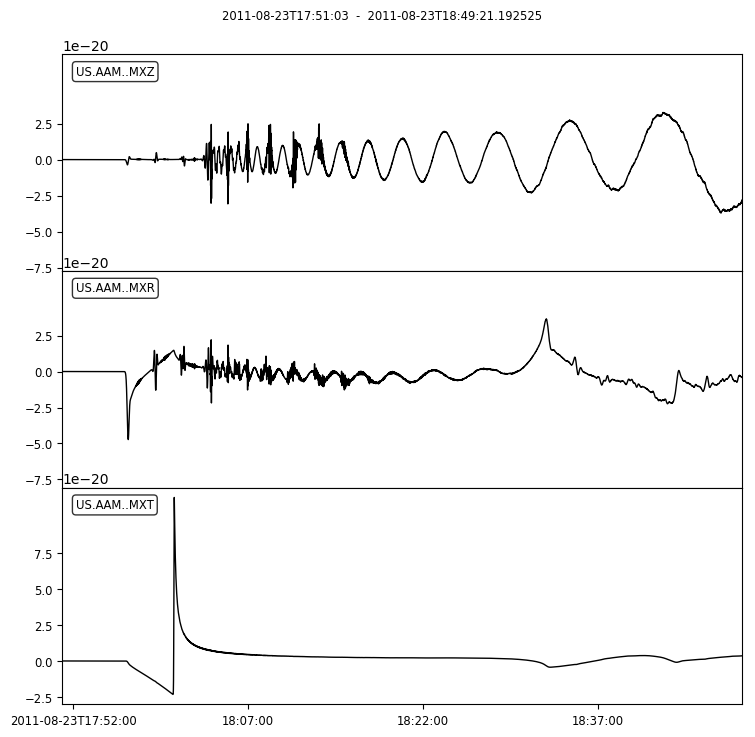

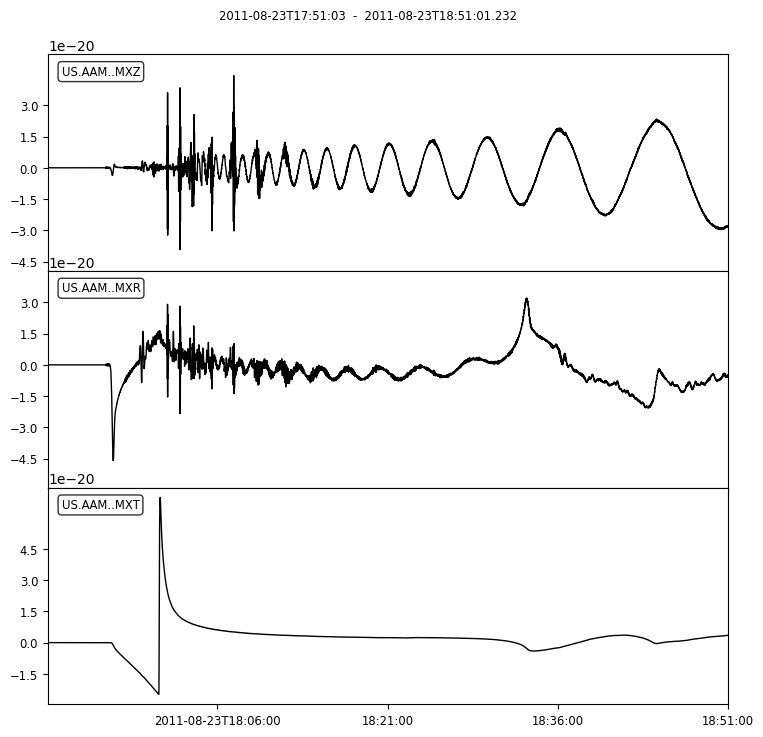

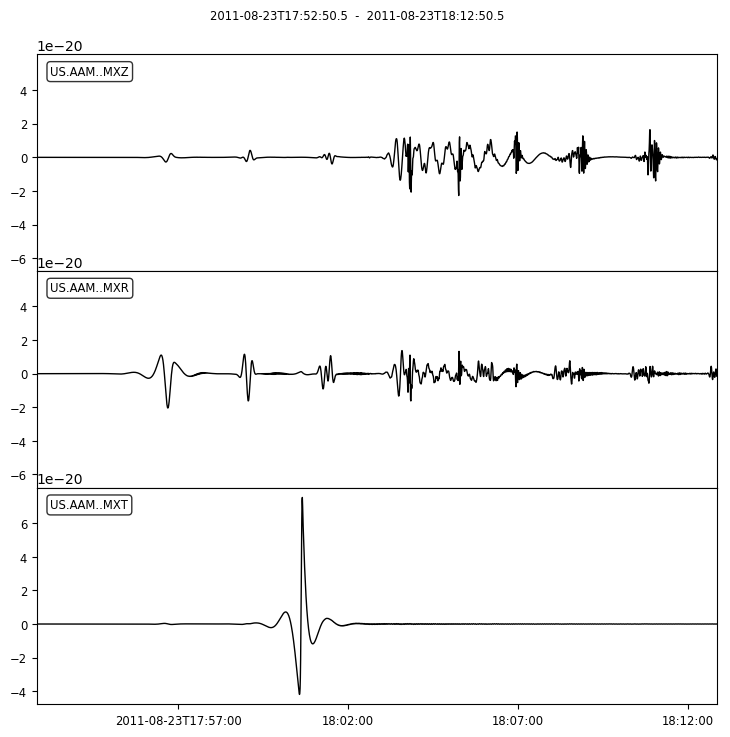

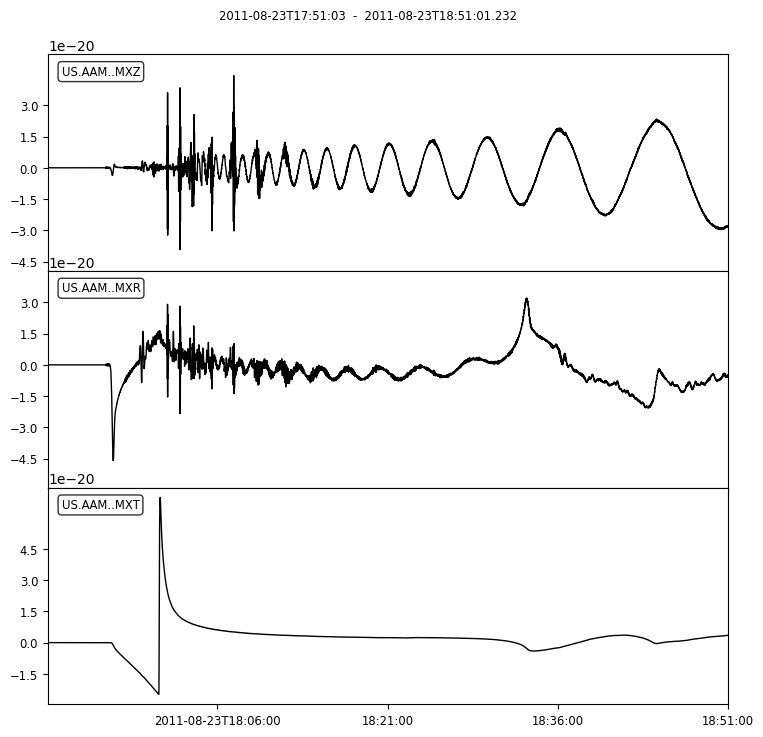

In [6]:
#define 'true' source parameters
normalize_factor = 1e17
m_rr_true = 4.710000e+17 / normalize_factor
m_tt_true = 3.810000e+15 / normalize_factor
m_pp_true = -4.740000e+17 / normalize_factor
m_rt_true = 3.990000e+16 / normalize_factor
m_rp_true = -8.050000e+16 / normalize_factor
m_tp_true = -1.230000e+17 / normalize_factor
evlo_true = -77.93
evla_true = 0.0
evdp_true = 2000.
mt_true = [m_rr_true,m_tt_true,m_pp_true,m_rt_true,m_rp_true,m_tp_true]

#define receiver parameters
stlo_true = -83.66
stla_true = 42.3 

#calculate expected P arrival
phase_arrs = europa_5km.get_travel_times_geo(source_depth_in_km=evdp_true/1000.0, 
                                             source_latitude_in_deg=evla_true,
                                             source_longitude_in_deg=evlo_true, 
                                             receiver_latitude_in_deg=stla_true,
                                             receiver_longitude_in_deg=stlo_true)
                                             #phase_list=['P'])
P_arr = phase_arrs[0]
t_arr = P_arr.time

#get synthetic data vector, and seismograms
data_true,st_true,st_eth = europa_synthesizer(mt_true,evlo_true,evla_true,
                                       evdp_true,stlo_true,stla_true,
                                       t_arr,t_start=-200,t_end=1000.0,
                                       freqmin=1/50.0,freqmax=1/2.0,
                                       sample_rate=2.0,scale_data=1e20,
                                       return_stream=True)

st_true.plot()
st_eth.plot()

### Plot 'true' synthetic data

/Users/rossmaguire/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


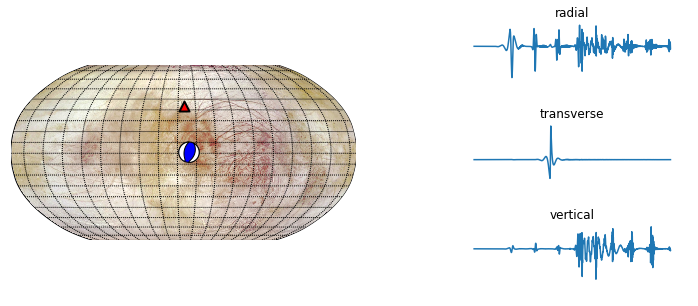

In [7]:
#plot map and 'true' (synthetic) data
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(projection='robin',lon_0=stlo_true)
m.drawmapboundary(fill_color='white')
m.warpimage('../data/images/europa_comp_800.jpg')
parallels=np.arange(-81.,81.,10.)
meridians=np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[False,False,False,False])
m.drawparallels(parallels,labels=[False,False,False,False])

x, y = m(evlo_true, evla_true)
#ax = plt.gca()
b = beach(mt_true, xy=(x, y), width=2000000, linewidth=1, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
x, y = m(stlo_true, stla_true)
ax.scatter(x,y,marker='^',color='r',s=100,zorder=99,
           edgecolor='k',linewidth=2)

#plot_waveforms
#radial
ax_r=fig.add_axes([1.15,0.75,0.5,0.2])
ax_r.plot(st_true[0].data)
ax_r.set_title('radial')
ax_r.set_axis_off()
ax_t=fig.add_axes([1.15,0.4,0.5,0.2])
ax_t.plot(st_true[1].data)
ax_t.set_title('transverse')
ax_t.set_axis_off()
ax_z=fig.add_axes([1.15,0.05,0.5,0.2])
ax_z.plot(st_true[2].data)
ax_z.set_title('vertical')
ax_z.set_axis_off()
plt.show()
#st_true.plot()

### Define Monte Carlo model

In [117]:
#define stochastic variables
m_rr = pm.Uniform('m_rr',lower=-10,upper=10)
m_tt = pm.Uniform('m_tt',lower=-10,upper=10)
m_pp = pm.Uniform('m_pp',lower=-10,upper=10)
m_rt = pm.Uniform('m_rt',lower=-10,upper=10)
m_rp = pm.Uniform('m_rp',lower=-10,upper=10)
m_tp = pm.Uniform('m_tp',lower=-10,upper=10)
mt = [m_rr,m_tt,m_pp,m_tp,m_rp,m_tp]

#define data variance
sigma = 0.25
tau = np.power(sigma,-2)

sample_rate = 2.0
scale_data = 1.0
return_stream = False
freqmin =1/50.0
freqmax = 1/2.0
t_start=-200
t_end = 1000.0
evla = evla_true
evlo = evlo_true
evdp = evdp_true
stla = stla_true
stlo = stlo_true
scale_data = 1e20

#define forward model
@pm.deterministic
def mu(m_rr=m_rr,m_tt=m_tt,m_pp=m_pp,m_rt=m_rt,m_rp=m_rp,m_tp=m_tp):
    
    source = instaseis.Source(
                       latitude=evla, 
                       longitude=evlo, 
                       depth_in_m=evdp,
                       m_rr = m_rr,
                       m_tt = m_tt,
                       m_pp = m_pp,
                       m_rt = m_rt,
                       m_rp = m_rp,
                       m_tp = m_tp,
                       origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    receiver = instaseis.Receiver(
               latitude=stla, 
               longitude=stlo, 
               network="US", 
               station="AAM")
    
    st = db.get_seismograms(source=source, receiver=receiver,
                            components='RTZ',kind='displacement')
    if sample_rate is not None:
        st.resample(sample_rate)
        
    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
    
    st_new = obspy.Stream()
    for tr in st:
        starttime = tr.stats.starttime + t_arr + t_start
        endtime = tr.stats.starttime + t_arr + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
    st = st_new
    
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    data_vector *= scale_data

    if return_stream:
        return data_vector,st
    else:
        return data_vector

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=data_true, observed=True)
#y = pm.Normal('y', mu=mu, tau=tau, value=data_true)

#inference
m = pm.Model([m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=50000,burn=10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 7808.2 sec

### Plot results

Text(0.5,1,u'm_tp')

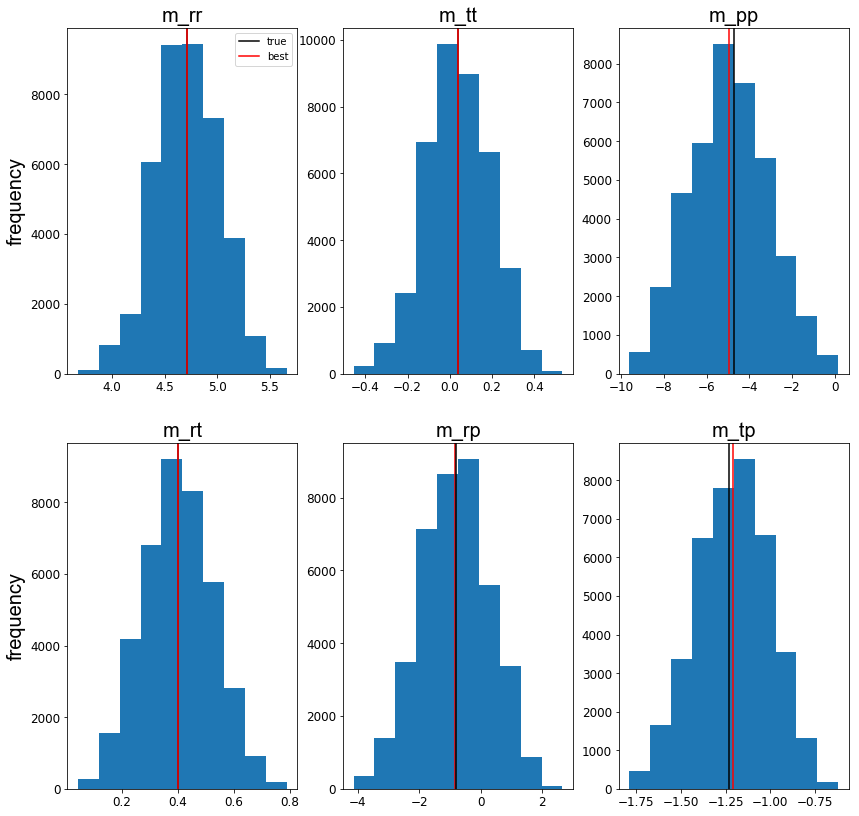

In [208]:
import matplotlib
from matplotlib.gridspec import GridSpec
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)
axis_font = {'fontname':'Arial', 'size':'20'}
fig = plt.figure(figsize=(14,14))
gs = GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
ax1.axvline(m_rr_true,c='k',label='true')
ax1.axvline(np.mean(m_rr.trace()),c='r',label='best')
ax1.hist(m_rr.trace())
ax1.set_title('m_rr',**axis_font)
ax1.set_ylabel('frequency',**axis_font)
ax1.legend()

ax2 = plt.subplot(gs[0,1])
ax2.axvline(m_tt_true,c='k')
ax2.axvline(np.mean(m_tt.trace()),c='r')
ax2.hist(m_tt.trace())
ax2.set_title('m_tt',**axis_font)

ax2 = plt.subplot(gs[0,2])
ax2.axvline(np.mean(m_pp.trace()),c='r')
ax2.axvline(m_pp_true,c='k')
ax2.hist(m_pp.trace())
ax2.set_title('m_pp',**axis_font)

ax4 = plt.subplot(gs[1,0])
ax4.axvline(m_rt_true,c='k')
ax4.axvline(np.mean(m_rt.trace()),c='r')
ax4.hist(m_rt.trace())
ax4.set_title('m_rt',**axis_font)
ax4.set_ylabel('frequency',**axis_font)

ax5 = plt.subplot(gs[1,1])
ax5.axvline(np.mean(m_rp.trace()),c='r')
ax5.axvline(m_rp_true,c='k')
ax5.hist(m_rp.trace())
ax5.set_title('m_rp',**axis_font)

ax6 = plt.subplot(gs[1,2])
ax6.axvline(np.mean(m_tp.trace()),c='r')
ax6.axvline(m_tp_true,c='k')
ax6.hist(m_tp.trace())
ax6.set_title('m_tp',**axis_font)

Text(0.5,1,u'MCMC Mean MT')

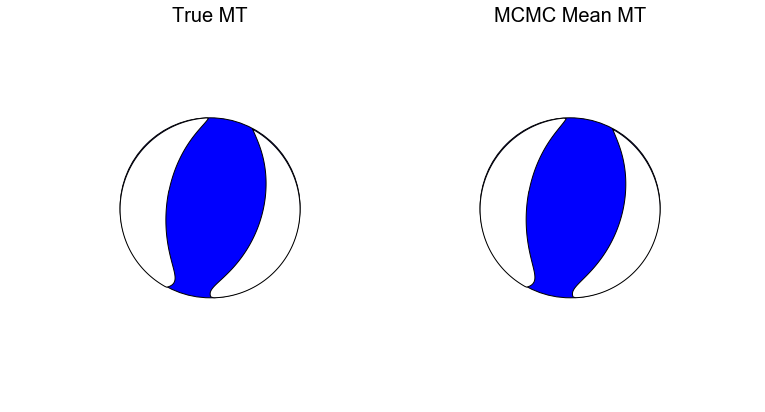

In [154]:
mt_mean = [np.mean(m_rr.trace()),np.mean(m_tt.trace()),
           np.mean(m_pp.trace()),np.mean(m_rt.trace()),
           np.mean(m_rp.trace()),np.mean(m_tp.trace())]
axis_font = {'fontname':'Arial', 'size':'20'}
fig=plt.figure(figsize=(10,10))
ax1=fig.add_axes([-0.5,-0.5,0.5,0.5])
b1 = beach(mt_true, xy=(0.5,0.5), width=0.5, linewidth=1, alpha=1.0)
ax1.add_collection(b1)
ax1.set_axis_off()
ax1.set_title('True MT',**axis_font)
ax2=fig.add_axes([0.0,-0.5,0.5,0.5])
b2 = beach(mt_mean, xy=(0.5,0.5), width=0.5, linewidth=1, alpha=1.0)
ax2.add_collection(b2)
ax2.set_axis_off()
ax2.set_title('MCMC Mean MT',**axis_font)

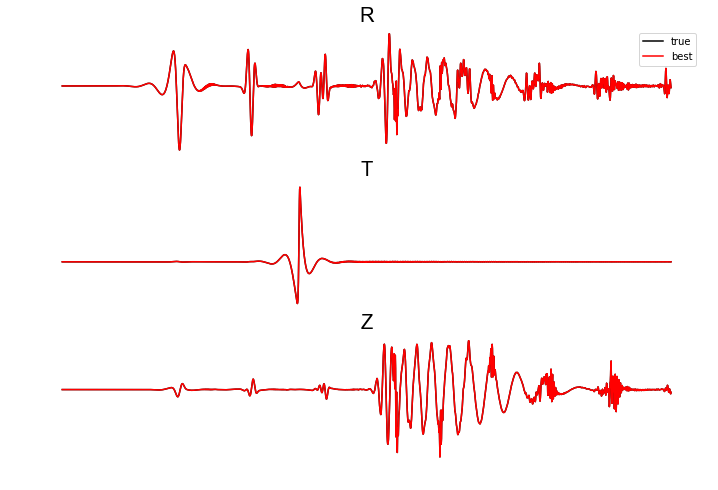

In [203]:
data_mean,st_mean = europa_synthesizer(mt_mean,evlo_true,evla_true,
                                       evdp_true,stlo_true,stla_true,
                                       t_arr,t_start=-200,t_end=1000.0,
                                       freqmin=1/50.0,freqmax=1/2.0,
                                       sample_rate=2.0,scale_data=1e20,
                                       return_stream=True)
fig = plt.figure(figsize=(12,8))
st_mean.sort()
gs = GridSpec(3,1)
ax1 = plt.subplot(gs[0,0])
ax1.plot(st_true[0].data,label='true',c='k')
ax1.plot(st_mean[0].data,label='best',c='r')
ax1.set_title('R',**axis_font)
ax1.legend()
ax1.set_axis_off()

ax2 = plt.subplot(gs[1,0])
ax2.plot(st_true[1].data,label='true',c='k')
ax2.plot(st_mean[1].data,label='best',c='r')
ax2.set_title('T',**axis_font)
ax2.set_axis_off()

ax3 = plt.subplot(gs[2,0])
ax3.plot(st_true[2].data,label='true',c='k')
ax3.plot(st_mean[2].data,label='best',c='r')
ax3.set_title('Z',**axis_font)
ax3.set_axis_off()